##Генетический алгоритм 
##Едленко С.А. 
##гр. 4.6

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import random
import torch
import math

In [9]:
def f(genes):
    return -((3. / (genes[0]*genes[0] + 8)) + (5. / (genes[1]*genes[1] + 8.)))

In [36]:
class GeneticAlgorithm:
    def __init__(self, population_size, num_genes, num_parents, mutation_prob, selection_method, parent_selection_method):
        self.population_size = population_size
        self.num_genes = num_genes
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.selection_method = selection_method
        self.parent_selection_method = parent_selection_method
        self.population = np.random.uniform(low=-20, high=20, size=(self.population_size, self.num_genes))
    
    def fitness(self, x, y):
        return -((3 / (x*x + 8)) + (5 / (y*y + 8)))
    
    def tournament_selection(self, fitness_scores):
        selected_parents = np.empty((self.num_parents, self.num_genes))
        for i in range(self.num_parents):
            tournament = np.random.choice(self.population_size, size=4, replace=False)
            tournament_fitness = fitness_scores[tournament]
            winner = tournament[np.argmin(tournament_fitness)]
            selected_parents[i,:] = self.population[winner,:]
        return selected_parents
    
    def roulette_selection(self, fitness_scores):
        total_fitness = np.sum(fitness_scores)
        relative_fitness = fitness_scores / total_fitness
        selected_parents = np.empty((self.num_parents, self.num_genes))
        for i in range(self.num_parents):
            r = np.random.random()
            cum_sum = 0
            for j in range(self.population_size):
                cum_sum += relative_fitness[j]
                if r <= cum_sum:
                    selected_parents[i,:] = self.population[j,:]
                    break
        return selected_parents
    
    def ranking_selection(self, fitness_scores):
        ranking = np.argsort(np.argsort(fitness_scores))
        selected_parents = np.empty((self.num_parents, self.num_genes))
        for i in range(self.num_parents):
            r = np.random.random()
            cum_sum = 0
            for j in range(self.population_size):
                cum_sum += (ranking[j] + 1) / self.population_size
                if r <= cum_sum:
                    selected_parents[i,:] = self.population[j,:]
                    break
        return selected_parents
    
    def uniform_ranking_selection(self, fitness_scores):
        ranking = np.argsort(np.argsort(fitness_scores))
        fitness_ranks = np.zeros_like(fitness_scores)
        fitness_ranks[ranking <= self.population_size // 2] = 1
        fitness_ranks /= np.sum(fitness_ranks)
        selected_parents = np.empty((self.num_parents, self.num_genes))
        for i in range(self.num_parents):
            r = np.random.random()
            cum_sum = 0
            for j in range(self.population_size):
                cum_sum += fitness_ranks[j]
                if r <= cum_sum:
                    selected_parents[i,:] = self.population[j,:]
                    break
        return selected_parents
    
    def sigma_pruning_selection(self, fitness_scores):
        mean_fitness = np.mean(fitness_scores)
        std_fitness = np.std(fitness_scores)
        threshold = mean_fitness - std_fitness
        selected_parents = self.population[fitness_scores >= threshold]
        if len(selected_parents) < self.num_parents:
            additional_parents = self.population[np.argsort(fitness_scores)[-self.num_parents+len(selected_parents):]]
            selected_parents = np.concatenate((selected_parents, additional_parents), axis=0)
        return selected_parents
    
    def panmixing_parent_selection(self, fitness_scores):
        return np.random.permutation(self.population)[:self.num_parents,:]
    
    
    def inbreeding_parent_selection(self, fitness_scores):
        return np.random.choice(self.population, size=self.num_parents)
    
    def outbreeding_parent_selection(self, fitness_scores):
        distances = np.zeros((self.population_size, self.population_size))
        for i, p1 in enumerate(self.population):
            for j, p2 in enumerate(self.population):
                if i == j:
                    continue
                distances[i,j] = np.sqrt(np.sum((p1 - p2)**2))
        indices = []
        for _ in range(self.num_parents):
            i, j = np.unravel_index(np.argmin(distances), distances.shape)
            indices.append(i)
            indices.append(j)
            distances[i,:] = np.inf
            distances[:,j] = np.inf
        return self.population[indices]
    
    def crossover(self, parents):
        offspring = np.zeros((self.num_parents, self.num_genes))
        for i in range(0, self.num_parents, 2):
            point = np.random.randint(0, self.num_genes)
            offspring[i,:point ] = parents[i,:point]
            offspring[i,point:] = parents[i+1,point:]
            offspring[i+1,:point] = parents[i+1,:point]
            offspring[i+1,point:] = parents[i,point:]
        return offspring

    def mutation(self, offspring):
        for i in range(self.num_parents):
            for j in range(self.num_genes):
                if np.random.uniform(0, 1) < self.mutation_prob:
                    offspring[i,j] = np.random.uniform(low=-10, high=10)
        return offspring

    def learn(self, num_generations):
        for generation in range(num_generations):
            fitness_scores = self.fitness(self.population[:,0], self.population[:,1])
            parents = getattr(self, f"{self.parent_selection_method}_parent_selection")(fitness_scores)
            offspring = self.crossover(parents)
            offspring = self.mutation(offspring)
            self.population[:self.num_parents,:] = parents
            self.population[self.num_parents:,:] = offspring
            fitness_scores = self.fitness(self.population[:,0], self.population[:,1])
            best_fitness = np.max(fitness_scores)
            best_individual = self.population[np.argmax(fitness_scores)]
            # print(f"Generation {generation}: Best fitness = {best_fitness:.4f}, Best individual = {best_individual}")
            if generation %  10 == 0:
              self.draw_function(self.population)


    def draw_function(self, individuals):

      # fig = plt.figure()
      # ax = fig.add_subplot(111, projection='3d')
      # ax.scatter(x, y, z)
      # plt.show()

      fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

      x = np.arange(-20, 20, 0.25)
      y = np.arange(-20, 20, 0.25)

      x, y = np.meshgrid(x, y)

      z = f([x,y])

      ax.plot_wireframe(x, y, z, rstride=10, cstride=10)
      
      x = np.array([ind[0] for ind in individuals])
      y = np.array([ind[1] for ind in individuals])
      
      z = np.array([self.fitness(ind[0], ind[1]) for ind in individuals])

      
      ax.scatter( x, y, z,color='black')

      plt.tight_layout()
      plt.show()

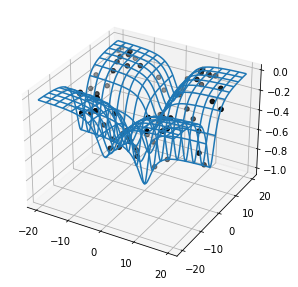

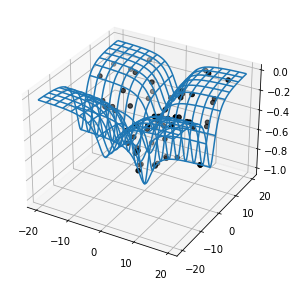

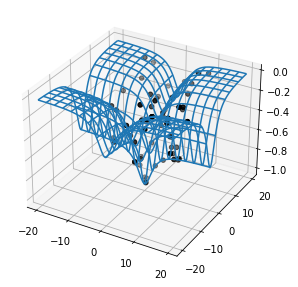

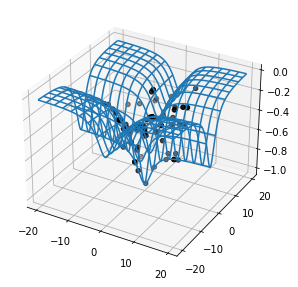

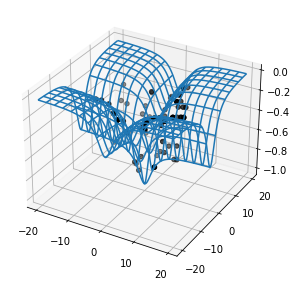

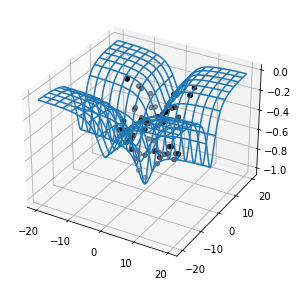

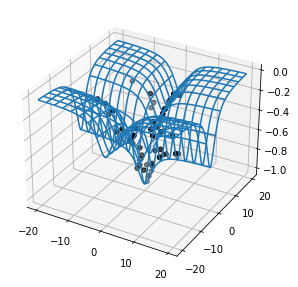

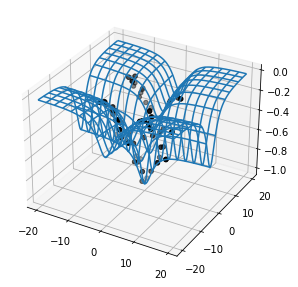

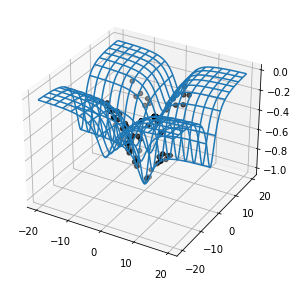

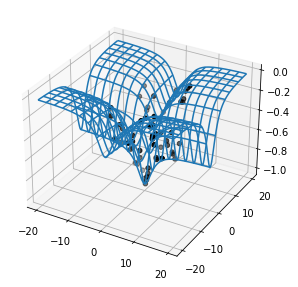

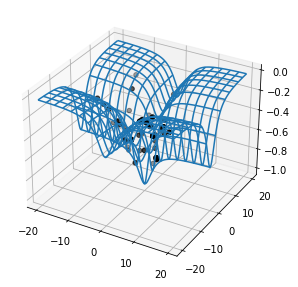

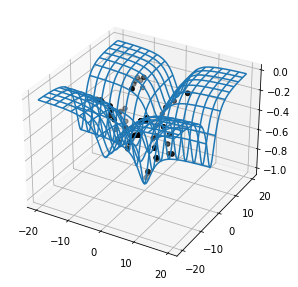

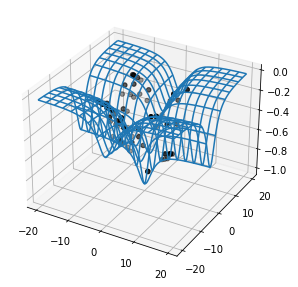

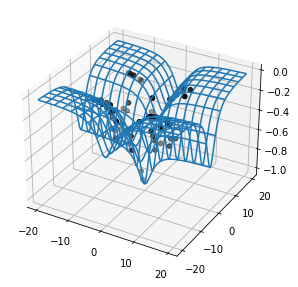

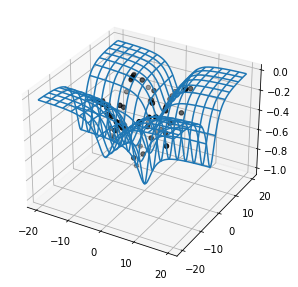

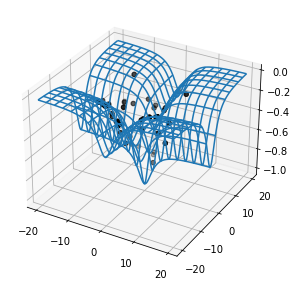

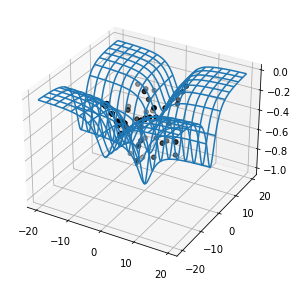

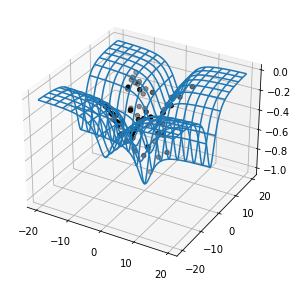

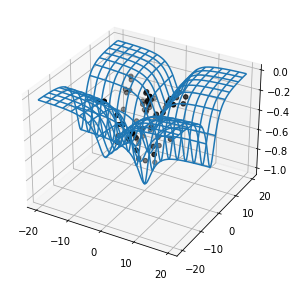

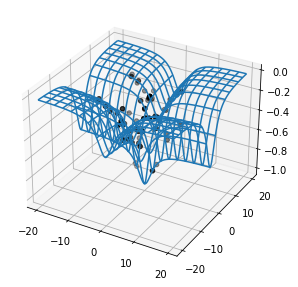

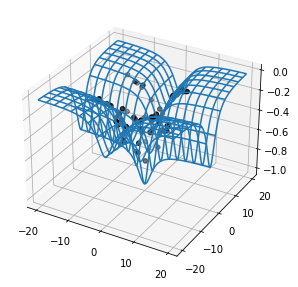

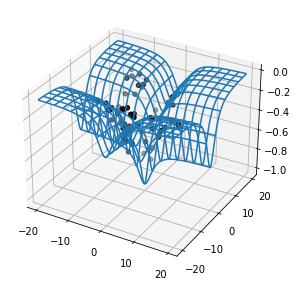

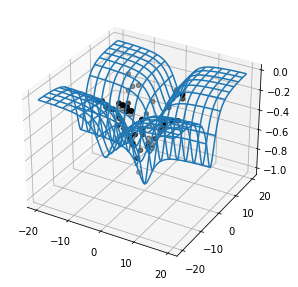

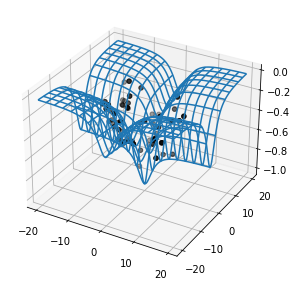

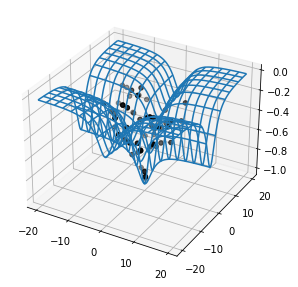

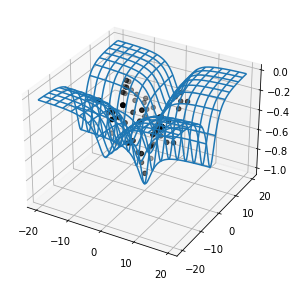

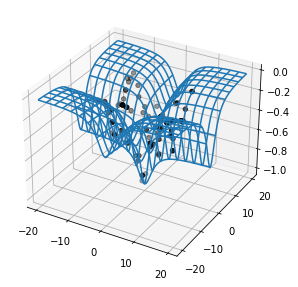

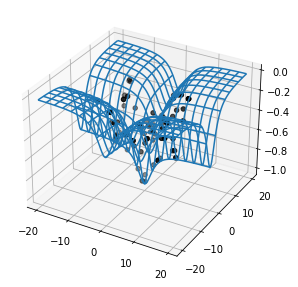

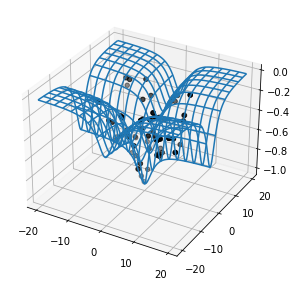

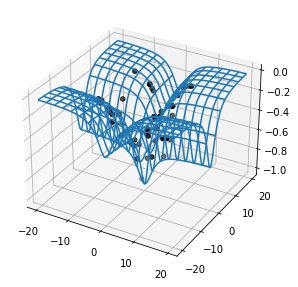

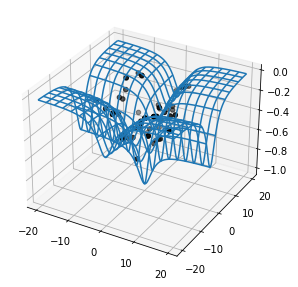

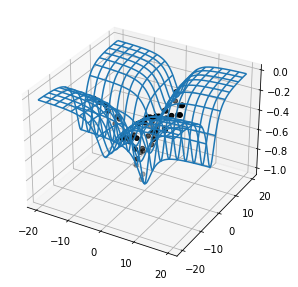

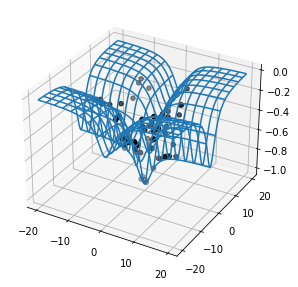

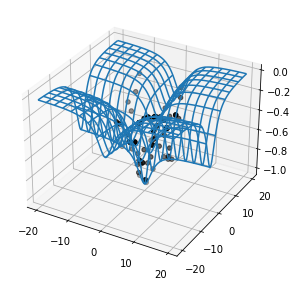

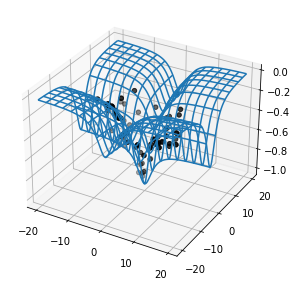

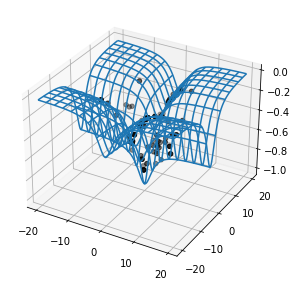

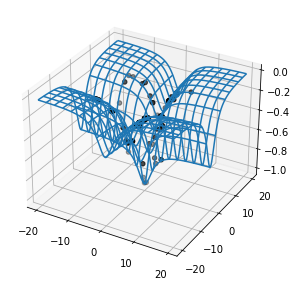

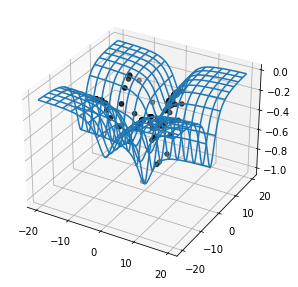

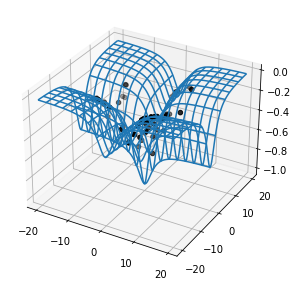

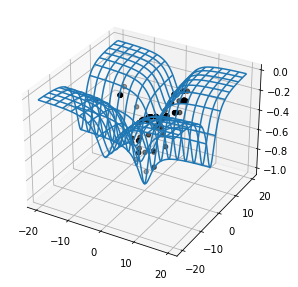

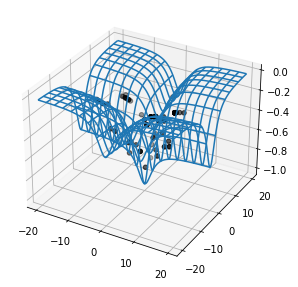

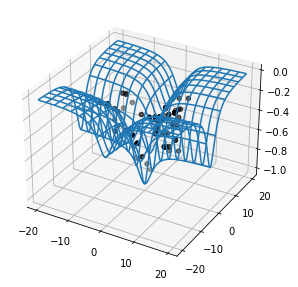

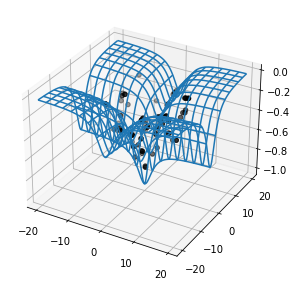

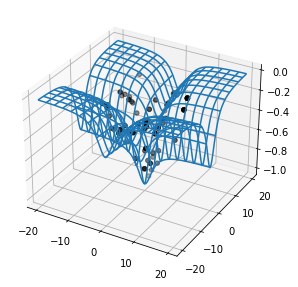

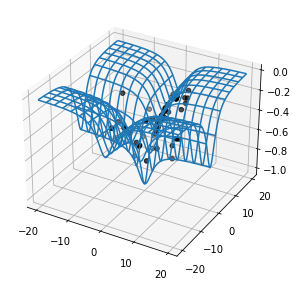

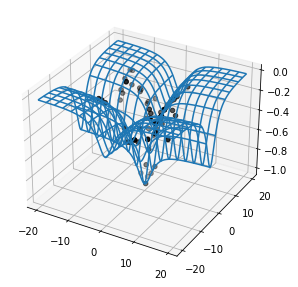

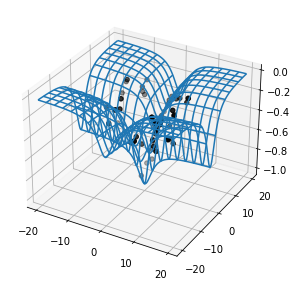

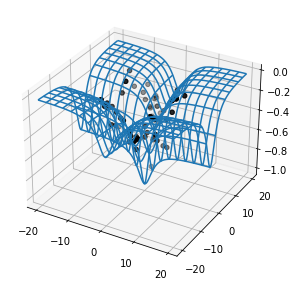

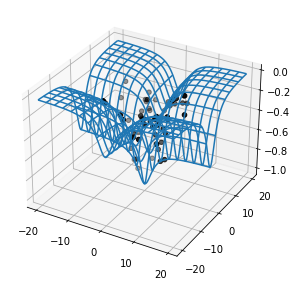

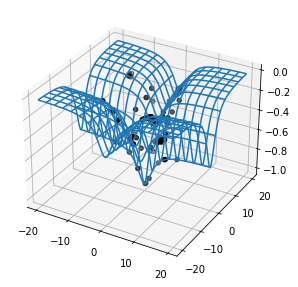

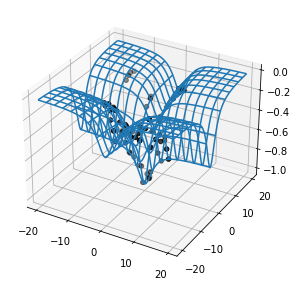

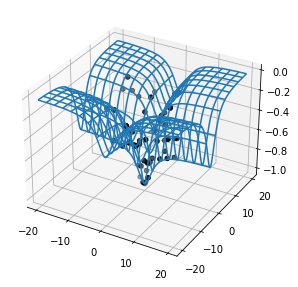

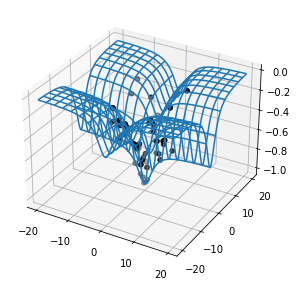

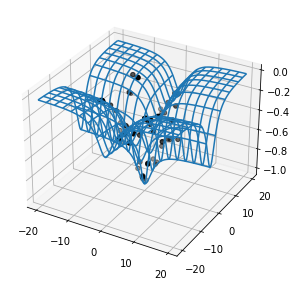

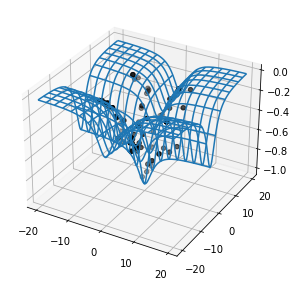

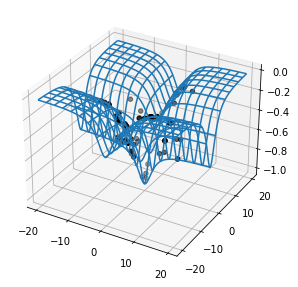

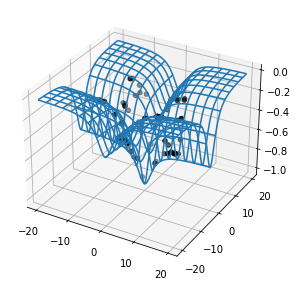

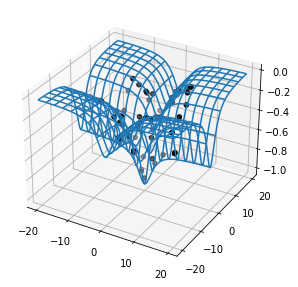

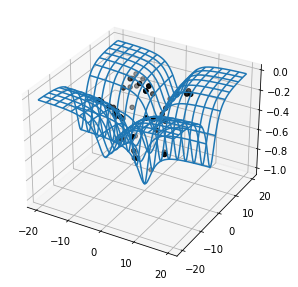

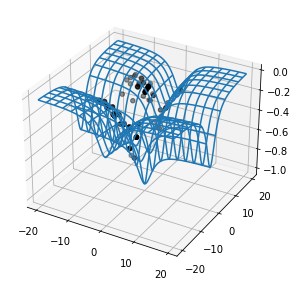

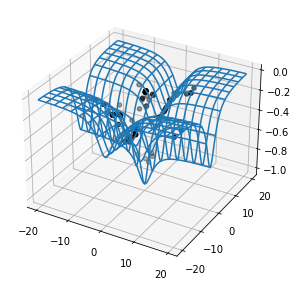

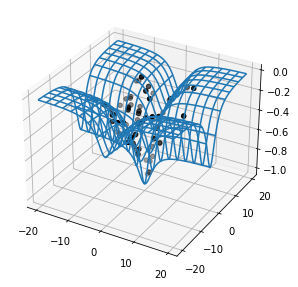

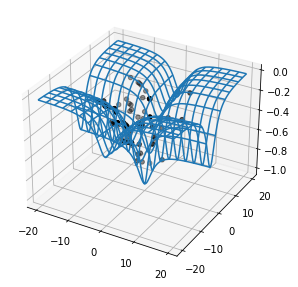

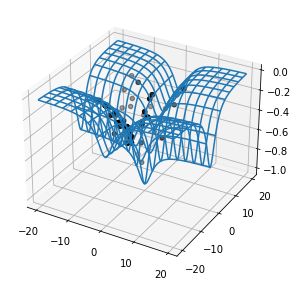

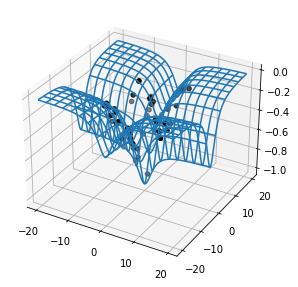

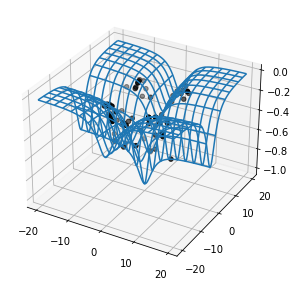

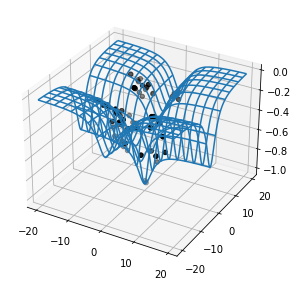

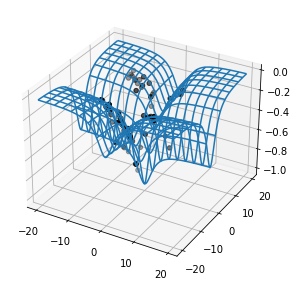

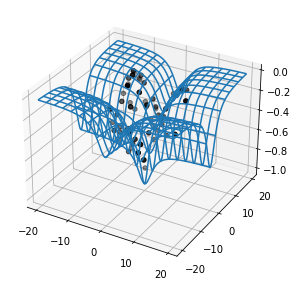

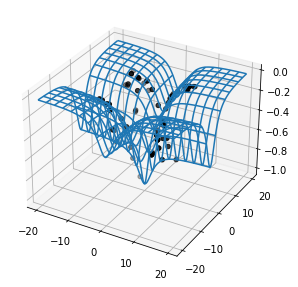

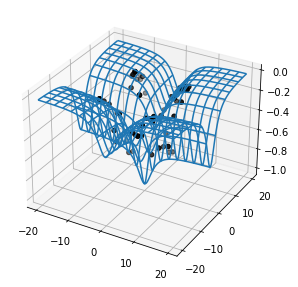

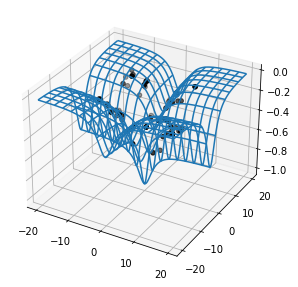

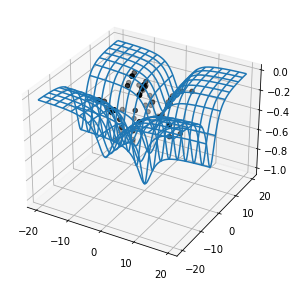

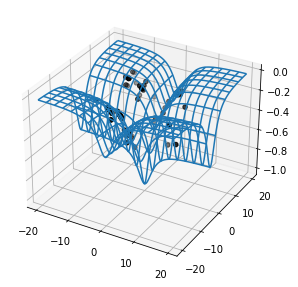

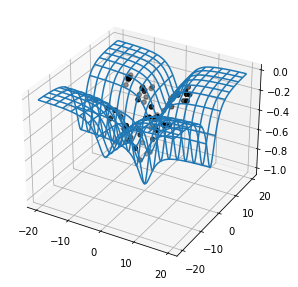

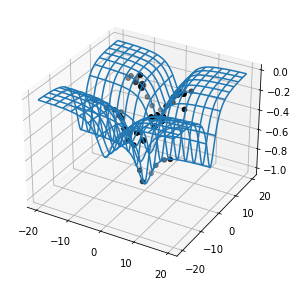

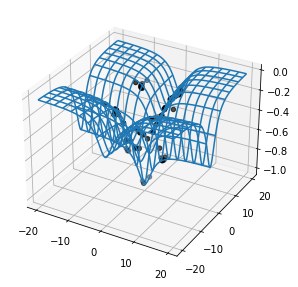

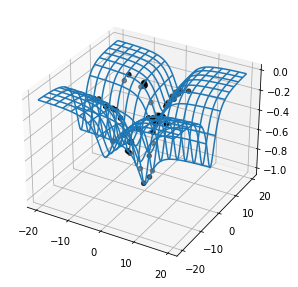

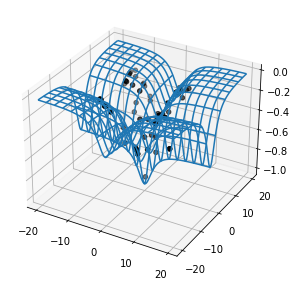

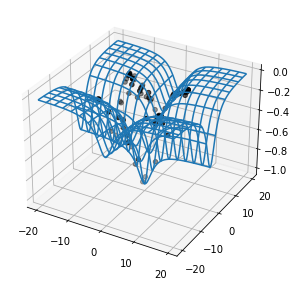

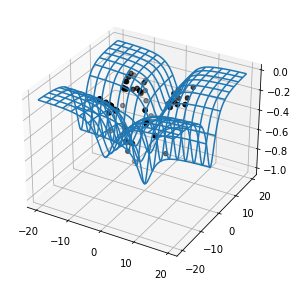

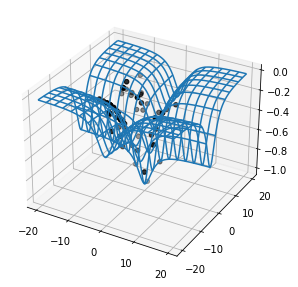

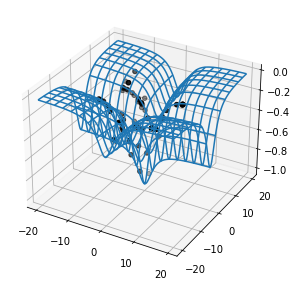

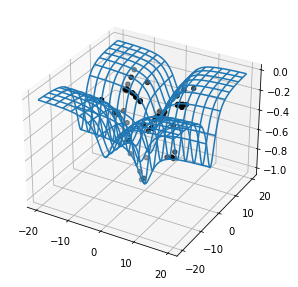

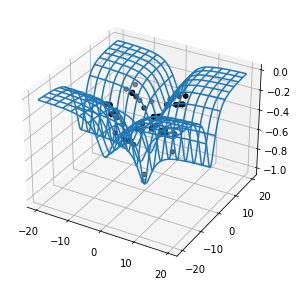

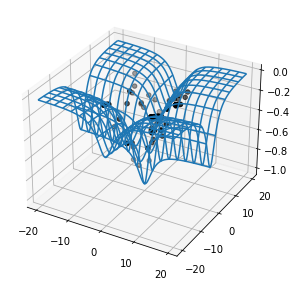

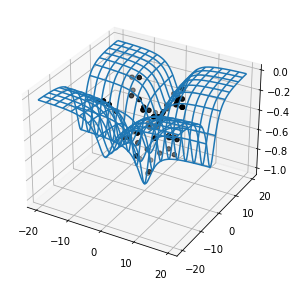

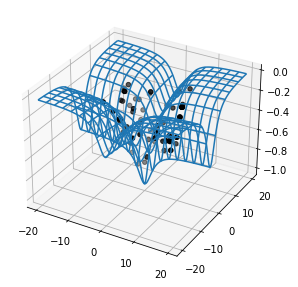

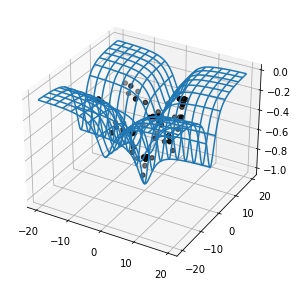

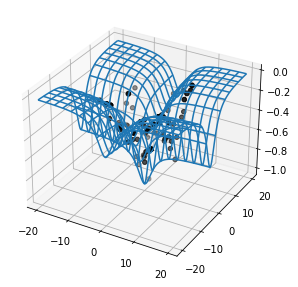

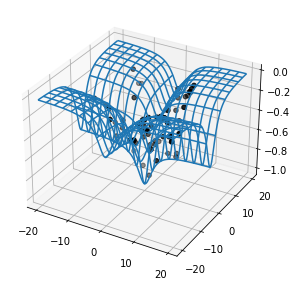

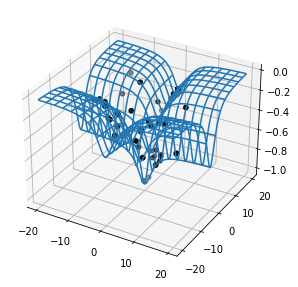

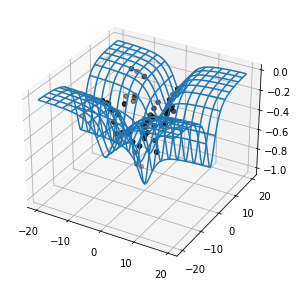

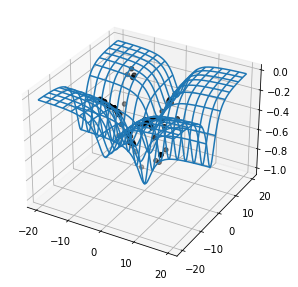

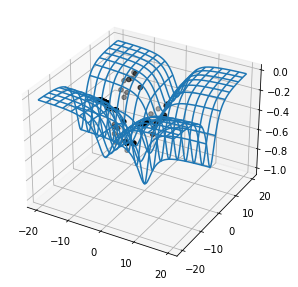

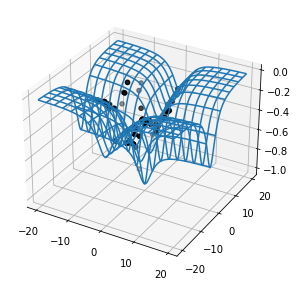

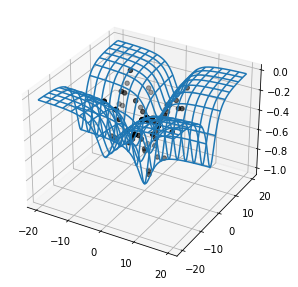

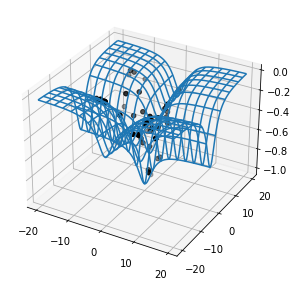

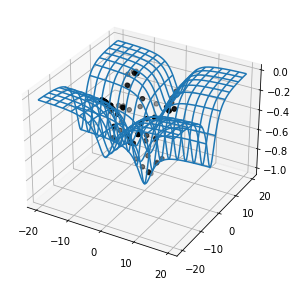

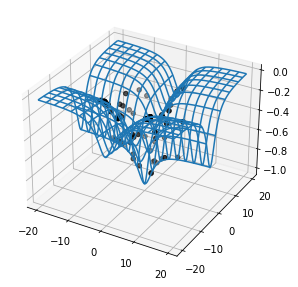

In [38]:
# create an instance of the GeneticAlgorithm class
ga = GeneticAlgorithm(population_size=100, num_genes=2, num_parents=50, mutation_prob=0.1, selection_method="tournament", parent_selection_method="panmixing")

# run the genetic algorithm for 100 generations
ga.learn(num_generations=1000)

